# Introduction to Machine Learning in Python

## Session Overview

Now that you've had some experience using R for data wrangling and presentation, we're going to move over to Python to look at **model training** and **model evaluation** in this session. These are the key components of the machine learning pipeline that inform our **model selection,** i.e. choosing an algorithm to solve our desired prediction task with data.

We're going to get some practice for two common types of machine learning tasks:

1. Regression (supervised learning)
2. Classification (supervised learning

It's important to note that model training and evaluation are not followed sequentially in practice, but instead iterated over to obtain the final model. We'll try to get a sense of what this looks like in the session.

### Why Python?
The content in today's session ccould be accomplished in either R or Python. Python is more widely used for machine learning tasks, especially when considering neural networks (which will be discucssed on Thursday). We are introducing today's material in Python to give a flavor of a different programming language, including its syntax and functionality. The material for today's session is adapted from **COS 2020's Modeling and ML** session using R. Feel free to refer to last year's [slides](https://github.com/adelarue/cos_2020/tree/master/4_modeling_and_ml) for similar session content in R syntax.

In [46]:
y_test.mean()

0.241674595623216

## Part 0: Preparing Data

To prepare our environment for today's session, we will begin by loading pandas, a core Python library for data analysis. Most of our machine learning work will be done using scikit-learn; we will load these libraries as we go through the session.

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
## Load the data
listings_raw = pd.read_csv('../data/listings_with_amenities.csv')

In [3]:
## Explore the first 10 rows
# listings_raw.head(10)

## Look at the columns
# listings_raw.columns;

## Describe the data (similar to summary() in R)
# listings_raw.describe().transpose()

Before moving forward, let's do some basic data cleaning.

In [4]:
listings_raw['review_scores_rating'].isna().mean()

0.22677824267782426

In [5]:
def clean_price(p):
    p = p.replace('$','').replace(',','') # replace all '$' and ',', similar to in R
    return float(p)

# We will "apply" this function to eacch element of our price column, and replace the price column with these values
listings_raw.loc[:,'price'] = listings_raw.loc[:,'price'].apply(lambda x: clean_price(x))
listings_raw.loc[:,'price']

0       250.0
1        65.0
2        65.0
3        75.0
4        79.0
        ...  
3580     69.0
3581    150.0
3582    198.0
3583     65.0
3584     65.0
Name: price, Length: 3585, dtype: float64

In [6]:
# We'll also clean up some outliers
listings_clean = listings_raw.query('accommodates <= 10 & price <= 1000')

# Filter by property type
listings_clean = listings_clean[listings_clean['property_type'].isin(["Apartment", "House", "Bed & Breakfast", "Condominium", "Loft", "Townhouse"])]
listings_clean = listings_clean[~listings_clean['neighbourhood_cleansed'].isin(["Leather District", "Longwood Medical Area"])]

# Find columns with sufficient fill (at most 25% missing values)
cols_keep = listings_clean.columns[listings_clean.isnull().mean() <= 0.25]
listings_clean = listings_clean.loc[:,cols_keep]

# Let's one-hot encode our property types
listings_clean = pd.get_dummies(listings_clean, columns = ['property_type'], drop_first = True)

# We're also going to filter to numeric columns for now- 
# You can use one-hot encoding to handle categorical variables, but today we'll stick to this.
listings_clean = listings_clean.select_dtypes(include=np.number)


In [7]:
# Where are there missing values?
missing_vals = listings_clean.isna().sum()
missing_vals.index[missing_vals>0]

Index(['bathrooms', 'bedrooms', 'beds', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

Let's impute the missing data - we will simply impute the mean. There are other options available in `sklearn.impute`.
Notice that the missingness is in numeric columns only, which makes it easier to deal with. If there are categoric columns with missing data, different approaches need to be taken (e.g. mode imputation).

In [8]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(listings_clean)

# Get the imputed values and convert back into a dataframe (it will return a matrix)
listings = pd.DataFrame(imp_mean.transform(listings_clean), 
                        columns = listings_clean.columns)

Let's see what our feature space looks like now.  

## Part 1: Regression

We're going to start by solving a regression problem.

**Inputs**

Regression is a supervised learning problem, which means that we have access to a dataset $\mathcal{D} = \{ (x_i, y_i) \}_{i = 1}^{n}$ where each $x_i \in \mathbb{R}^d$ and each $y_i \in \mathbb{R}$.

Note that for regression, the output, $y$, is *continuous*. If the output is discrete, such as whether or not an apartment listing will be rented (yes/no) or what town the unit is listed in (multiple classes: Boston vs. Cambridge vs. Somerville), we would use a *classification* algorithm. We will consider these in part 2 of the session.
 
**Aim**

The aim of a regression task is to find a function $h: \mathbb{R}^d \to \mathbb{R}$ which allows us to compute an accurate prediction of the output, $y$, for any given input, $x$. These new $x$ and $y$ are *unseen*: that is, we assume they are identically distributed relative to the points in $\mathcal{D}$, but independent.

Exactly what we mean by *accuracy* will be discussed when we talk about model evaluation.

The way we approach the problem of finding $h$ is by selecting a parameterised class of models, and solving an optimization problem to find the best model within this class according to a *loss function*. We usually repeat this process for several model classes.

### Defining our Regression Task

We're going to use the Boston Airbnb dataset, where each entry is a property listing, and aim to use the input variables available to us in order to predict the price of a listing.

Note here that we haven't specified exactly which variables in the dataset will be used to define each $x_i$. This choice of **feature space** is part of the modeling process, and we will experiment with it.

### Ordinary Least Squares

The first class of models we're going to try is linear models. This means we hypothesise that the output, $y$, can be described using a linear combination of the inputs, $x$: $h(x) = \beta^{\intercal} x$.

**Question**: What are the tunable parameters (hyperparameters) for the class of OLS models?

**Answer**: There aren't really any. If we restrict ourselves to OLS, then the only choice we need to make is which variables to include as inputs.

#### Fitting an OLS Model 

Now, we need to choose exactly which inputs will be used for fitting the model. Which inputs might be predictive of price? Recall the column names:

For a very simple model, let's just choose `accommodates` as the only input. To fit this model we will use linear regression in scikit-learn:

In [9]:
from sklearn.linear_model import LinearRegression

X = listings[['accommodates']]
y = listings['price']

# Select the model type
model = LinearRegression()

# Fit the model to our data
model.fit(X, y)

LinearRegression()

We've trained our first model! Let's look at the model output. You can see the elements of the `model` object by typing `model.` and pressing "tab."

In [10]:
print(model.coef_)
print(model.intercept_)

[38.18345374]
53.65979354996023


Let's look at the 'coefficients' section. In the 'estimate' column, we see that the point estimates for the model coefficients say that the price estimate is \\$53.65 + \\$38.18*$(# of people accommodated). 

To visualise the model, let's plot the fitted line. We'll use `matplotlib` for our plotting, which offers similar functionality to `ggplot2` in R.

Text(0.5, 1.0, 'OLS Model Fit')

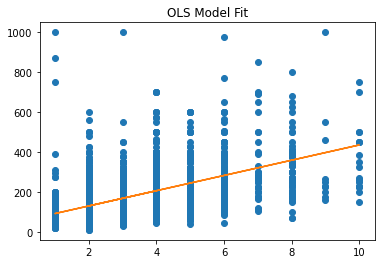

In [11]:
import matplotlib.pyplot as plt

# Start with a scatterplot of the data
plt.plot(X, y, 'o')

# Add in the regression line
y_pred = model.predict(X)
plt.plot(X, y_pred)
plt.title('OLS Model Fit')

Let's look the model residuals for each accommodation size to see how appropriate the linear model is for this problem. 

<AxesSubplot:xlabel='accommodates', ylabel='ols_resid'>

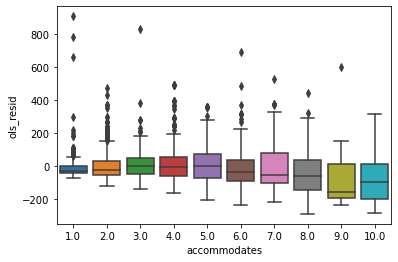

In [12]:
import seaborn as sns # another helpful plotting library

# We'll add the OLS predictions and residuals to our dataframe, and then plot them
resid = (y - y_pred)
listings['ols_pred'] = y_pred
listings['ols_resid'] = resid
sns.boxplot(x='accommodates', y='ols_resid', data=listings)


**Question**: What do these box plots tell us about the model?

**Answer**: Although the residuals seem relatively centered around zero, there does appear to be some right skew. Also, the higher accommodation residuals look less centered. Perhaps the model doesn't apply so well here.


### Evaluation

Now we're going to look at two measures of accuracy for regression models -- in other words, how well a model explains a dataset.

The first is the mean squared error (MSE), which is simply computed as the mean of the squared residuals. Recall that the residuals are stored in the `resid` variable:

In [13]:
mse = np.mean(resid**2)
mse

8524.686882553635

We can also calculate the RMSE, (root) MSE, from a model applied to a dataset:

In [14]:
rmse = np.sqrt(np.mean(resid**2))
rmse

92.32923092148897

Scikit-learn has built-in evaluation functions that can do this for you. We'll also print the results out using Python's number formatting to show the MSE/RMSE rounded to two decimals.

In [15]:
from sklearn import metrics
mse = metrics.mean_squared_error(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared = False)
print("MSE = %.2f" % mse)
print("RMSE = %.2f" % rmse)

MSE = 8524.69
RMSE = 92.33


Clearly this measure is highly affected by the scale of the data. We can also use the 'R squared' coefficient, which is more interepretable since it is on a standardized scale.

In [16]:
def r_squared(y_true, y_pred, y_mean):
    ss_res = ((y_true - y_pred)**2).sum()
    ss_tot = ((y_true - y_mean)**2).sum()
    return (1 - (ss_res/ss_tot))

r2 = r_squared(y, y_pred, np.mean(y))
print("R^2 = %.2f" % r2)

R^2 = 0.32



The R squared value is what we will use to evaluate the performance of our models in this session. But, it's important to note that this is definitely not the only choice we could have made! Check out scikit-learn's full library of [evaluation metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) to see what else is out there.

**Question**: What is the relationship between the loss function and the measure of accuracy used to evaluate a model? How do we know which is the best choice for each?

**Answer**: The loss function is used to fit a model, and the measure of accuracy is used to evaluate how well it explains the data. The measure of accuracy usually comes from the task we aim to solve, and the loss function is often something that we will play around with until we find a good model. 

#### Training, Validation and Testing Splits

Recall that our ultimate goal in this supervised learning task is to be able to predict price ($y$) from an *unseen* set of inputs ($x$, although we are still playing around with the input variables which define it).

When building the OLS model, we used the entire dataset. Simply taking the R squared value on this dataset as a measure of performance is clearly not fair -- since we want the model to generalise to unseen data.

To address this problem, we often split the dataset into three different chunks:

1. **Training data**: the data we build our models on.
2. **Validation data**: the data we tune hyperparameters on.
3. **Testing data**: the data we use to obtain a final estimate of performance.

The validation set is like an 'intermediate' estimate of performance. If we didn't use the validation set for this purpose, the only way of selecting the best model from a model class would be to look at its performance on the training set or the testing set.

`train_test_split` in scikit-learn provides an easy way of creating these data partitions. Let's start by just creating training/testing sets. We'll get to parameter tuning in a minute.

In [17]:
from sklearn.model_selection import train_test_split

features =  listings.columns.drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 
                                   'host_total_listings_count','calculated_host_listings_count',
                                   'price', 'ols_pred', 'ols_resid'])

X_train, X_test, y_train, y_test = train_test_split(listings[features], listings['price'], 
                                                    train_size = 0.75, random_state = 20)

print("Training Size = %d" % X_train.shape[0]) # To print integers, we can pass '%d' into our print statement 
print("Testing Size = %d" % X_test.shape[0])

Training Size = 2625
Testing Size = 876



### Model Iteration

Now that we're equipped to build models and evaluate their performance, let's start iterating to find better models.

We've glossed over the precise choice of variables to use in order to explain price, so let's try a few different combinations. 

Now we'll write a function that accepts data (X,y) and splits into training/testing data, fits a model, and returns the R squared value on each partition.

In [18]:
def eval_ols(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = metrics.mean_squared_error(y_train, y_train_pred, squared = False)
    rmse_test = metrics.mean_squared_error(y_test, y_test_pred, squared = False)
    
    print("Train RMSE = %.2f" % rmse_train)
    print("Test RMSE = %.2f" % rmse_test)
    
    rsq_train = r_squared(y_train, y_train_pred, np.mean(y_train))
    rsq_test = r_squared(y_test, y_test_pred, np.mean(y_train))
    
    print("Train R^2 = %.2f" % rsq_train)
    print("Test R^2 = %.2f" % rsq_test)

def train_eval_ols(X, y, split_seed = 20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = split_seed)
    
    model = LinearRegression().fit(X_train, y_train)
    eval_ols(model, X_train, y_train, X_test, y_test)

#     return rsq_train, rsq_test


**Question**: Why do we compare to `y_train` when calculating $R^2$ on the test set?

**Answer**: $R^2$
compares the model's predictions to a baseline prediction of simply predicting the average that we see in our data. When applying a model to a test set, we don't know the average of the test set. Our baseline action would be to predict the average of our test set.

And now we'll build and evaluate a series of OLS models together, one for each formula:

**Exercise**: Using the function previously defined, build and evaluate the models.

In [19]:
print("Price ~ Accomodates")
train_eval_ols(listings[['accommodates']], listings['price'])
print("\nPrice ~ Accomodates + Reviews/Month")
train_eval_ols(listings[['accommodates','reviews_per_month']], listings['price'])
print("\nPrice ~ Accomodates + Reviews/Month + Rating")
train_eval_ols(listings[['accommodates','reviews_per_month','review_scores_rating']], listings['price'])
print("\nPrice ~ All Variables")
train_eval_ols(listings[features], listings['price'])

Price ~ Accomodates
Train RMSE = 90.24
Test RMSE = 98.43
Train R^2 = 0.32
Test R^2 = 0.32

Price ~ Accomodates + Reviews/Month
Train RMSE = 89.03
Test RMSE = 96.72
Train R^2 = 0.34
Test R^2 = 0.35

Price ~ Accomodates + Reviews/Month + Rating
Train RMSE = 88.53
Test RMSE = 96.38
Train R^2 = 0.35
Test R^2 = 0.35

Price ~ All Variables
Train RMSE = 75.84
Test RMSE = 87.56
Train R^2 = 0.52
Test R^2 = 0.46



**Question**: Can we say anything definitive about these results?

**Answer**: We can be relatively confident that the largest model is the best performing. We also see that the testing performance is significantly worse than the training performance. Usually this indicates overfitting. Also notice that the $R^2$'s vary as we change seed; our performance estimates are sensitive to the randomness used to select the training/testing partitions. We can check this by changing the random seed defined earlier. Cross-validation, which we will introduce, is one way of addressing this problem.

### Regularization

In some situations, overfitting is more obvious -- and since it is a common problem when building models, we will now look at how it can be addressed.

Regularization is a tool which helps us to avoid overfitting by penalising model complexity. Mathematically, we add a term to the loss function in the optimisation problem to be solved. Recall that the OLS formulation we've worked with is:

$$\min_w \: \frac{1}{n} \sum_{i = 1}^{n} (w^\intercal x_i - y_i)^2$$

With a regularization term, this becomes:

$$\min_w \: \frac{1}{n} \sum_{i = 1}^{n} (w^\intercal x_i - y_i)^2 + \lambda \Omega(w)$$


$\Omega(w)$ is a penalty on the complexity of the model. Two common choices for $\Omega(w)$ are:

1. $\Omega(w) = ||w||_2^2$: this is ridge regression.
2. $\Omega(w) = ||w||_1$: this is LASSO regression.

Both types of regression shrink the elements of the optimal $w^*$ vector towards 0 -- but in different ways. We will focus on LASSO -- which tends to shrink the coefficients so that some are equal to 0. This is nice because it helps us interpret the model by making it *sparser*.

### Cross-Validation

We need a way of selecting the one with the best parameter for our task.

**Question**: How would we do this using the training/validation/testing splits?

**Answer**: Fit models on the training set, varying lambda. Then obtain an estimate of performance for each model on the validation set, and choose the best. Obtain a final estimate of performance for this model on the testing set.

Here, because `GridSearchCV` makes it easy, we're going to use a similar technique called cross-validation. Generally, we only consider this necessary when we're worried we have too little training data to obtain an accurate estimate of validation performance.

The idea behind cross-validation is: repeating the training/validation process multiple times provides us with several estimates of validation performance. Taking the average of these hopefully gives us an estimate which is less affected by noise.

To cross-validate, we start with only two partitions of the dataset:

1. Combined training/validation set: the data that we repeatedly train and validate on.
2. Testing set: the data we obtain our final performance estimate on.

But, how do we train and validate?

- First, select a number of *folds*.
- Then divide the training/validation data into this number of equal-sized partitions.
- For each fold, repeat the training/validation procedure. The fold is the validation data, and the other folds are training data.
- Average the performance of each model across folds and pick the hyperparameters which produce the best model.
- Fit a model on the entire training set using the selected values of hyperparameters.



We'll use our training set from before and run 5-fold cross-validation to determine the best `alpha`.

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define the grid that we want to search over
grid = {'alpha':np.arange(0.01, 1, 0.01)}

# Define the parameters for the model 
gs = GridSearchCV(Lasso(max_iter=1e6), grid, cv=5)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m = gs.best_estimator_

## Print the best parameters determined by the cross-validation
print("Alpha: %.3f" % gs.best_params_['alpha'])

Alpha: 0.670


In [21]:
coef_output = pd.DataFrame({'feature':X_train.columns,
              'coefficient':m.coef_})
print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 36


,feature,coefficient
24,amenity_Free_Parking_on_Premises,-33.749775
68,property_type_House,-18.095883
40,amenity_Lock_on_Bedroom_Door,-10.025009
19,review_scores_value,-8.631489
25,amenity_Pets_live_on_this_property,-6.634202
...,...,...
2,bathrooms,18.908924
37,amenity_Air_Conditioning,19.010524
21,amenity_TV,22.145670
61,amenity_Elevator_in_Building,23.432671


Let's see how our error changes with our penalty term (called alpha in the Lasso() implementation). As the penalty increases, the fitted models have more and more nonzero coefficients. We can visually see how thee error changes with lambda. It looks pretty flat at values slightly larger than 0.67, meaning that we could potentially increase interpretability at close to no loss in prediction accuracy. 

(-50.0, 2.0)

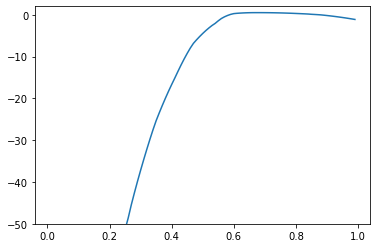

In [22]:
param_results = pd.DataFrame({'params':gs.cv_results_['params'], 
              'params_numeric':np.arange(0.01,1,0.01), 
              'score':gs.cv_results_['mean_test_score']})
plt.plot(param_results['params_numeric'],param_results['score'])
plt.ylim([-50,2])

We still haven't obtained an error measurement on the testing data, which will allow us to compare our best regularised model with the unregularised one. 

Let's generate predictions and calculate our performance metrics:

In [23]:
eval_ols(gs, X_train, y_train, X_test, y_test)

Train RMSE = 76.73
Test RMSE = 87.35
Train R^2 = 0.51
Test R^2 = 0.47


Let's see how well we do if we use a higher alpha parameter, even though its slightly suboptimal.

In [24]:
clf = Lasso(alpha=0.8)
clf.fit(X_train, y_train)
eval_ols(clf, X_train, y_train, X_test, y_test)
print("Number of zeros: %d" % sum(clf.coef_ == 0))

Train RMSE = 76.85
Test RMSE = 87.41
Train R^2 = 0.51
Test R^2 = 0.47
Number of zeros: 39


The previous best model had a test RMSE of 87.56 (and $R^2$ of 0.46), so we now have a slightly better model. Regularization has also given us a way of obtaining an accurate model with fewer nonzero coefficients. Even when taking the higher suboptimal alpha, we still do nearly as well with even higher interpretability. 

## Part 2: Classification
So far we've looked at models which predict a continuous response variable. There are many related models which predict categorical outcomes, such as whether an email is spam or not, or which digit a handwritten number is. We'll take a brief look at three of these: logistic regression and classification trees.

### Logistic Regression
Logistic regression is part of the class of generalized linear models (GLMs), which build directly on top of linear regression. These models take the linear fit and map it through a non-linear function. Linear regression has the form $$y_i=w_0+w_1 x_{i,1}+w_2 x_{i,2}=w^Tx_i,$$ whereas a GLM model has the form $$y_i=f(w^Tx_i)$$ For logistic regression, the function $f()$ is given by $f(z) = 1/(1+\exp(-z))$ (the *logistic function*).

Let's apply a logistic regression model to the `listings` data. Let's try to predict which listings have elevators in the building by using `price` as a predictor. Remember that our `amenity_Elevator_in_Building` variable already stores our binary outcome of interest (1 = elevator, 0 = no elevator).

We need to re-split our data with y as the `amenity_Elevator_in_Building` variable. We will also *stratify* our split on this variable, meaning that the data is split to preserve the ratio of units with elevators in both the training and testing sets.

In [25]:
features =  listings.columns.drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 
                                   'host_total_listings_count','calculated_host_listings_count',
                                   'amenity_Elevator_in_Building', 'ols_pred', 'ols_resid'])
X_train, X_test, y_train, y_test = train_test_split(listings[features], listings['amenity_Elevator_in_Building'], 
                                                    train_size = 0.7, random_state = 2,
                                                   stratify = listings['amenity_Elevator_in_Building'])


Instead of linear regression, we'll now use `LogisticRegression()`, but the syntax is very similar. We'll skip ahead directly to using a grid search to tune regularization parameters. As you can see, the same steps apply even with a new model:
1. Define a parameter grid
2. Initialize a GridSearchCV object with the tuning grid and other fixed parameters
3. Fit the model!

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05), 
              'penalty': ['l2','l1'], 
              'solver': ['liblinear']}

# Define the parameters for the model 
gs = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)
## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_lr = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'C': 0.501, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
              'coefficient':m_lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 13


,feature,coefficient
68,property_type_House,-3.043849
49,amenity_other_50,-0.681879
52,amenity_Indoor_Fireplace,-0.600200
70,property_type_Townhouse,-0.518446
25,amenity_Free_Parking_on_Premises,-0.504423
...,...,...
69,property_type_Loft,0.925672
62,amenity_Pool,1.073132
63,amenity_Doorman,1.952360
50,amenity_Gym,2.122397


We can now explore out-of-sample performance. Ultimately, we want to predict whether or not a listing has an elevator. However, logistic regression gives us something a bit different: a probability that each listing has an elevator. This gives us flexibility in the way we predict. The most natural thing would be to predict that any listing with predicted probability above 0.5 *has* an elevator, and any listing with predicted probability below 0.5 *does not have* an elevator. But what if I use a wheelchair and I want to be really confident that there's going to be an elevator? I may want to use a cutoff value of 0.9 rather than 0.5. In fact, we could choose any cutoff value and have a corresponding prediction model.	

This is where AUC comes in. For every cutoff, we'll plot the *false positive rate* against the *true positive rate* and then take the area under this curve.	

**Question**: As a sanity check: What is the true positive rate and false positive rate of a random classifier that chooses "has an elevator" with probability of $\alpha$? (i.e. a classifier that randomly predicts *positive* $\alpha$% of the time.) What is the AUC for this classifier?

**Answer**: Both the true positive rate and false positive rate are $\alpha$. The AUC is 0.5.

scikit-learn allows us to easily plot ROC curves and calculate AUC. Here's an example. We'll write our evaluation in a function so that we can evaluate other models in the same way.

Train AUC: 0.920
Test AUC: 0.894


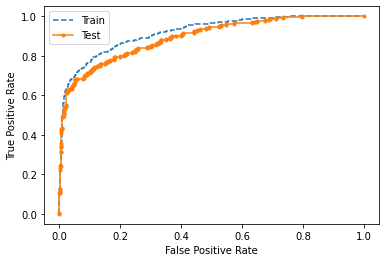

In [28]:
train_pred = m_lr.predict_proba(X_train)[:,1]
test_pred = m_lr.predict_proba(X_test)[:,1]

print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))

train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
plt.plot(test_fpr, test_tpr, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

We can also look at threshold-based metrics. By selecting a decision threshold $t$, we predict all observations with a predicted probability $\hat{y} \geq t$ to have an elevator and all others to have no elevator. 

Let's calculate the training and testing accuracy for our model:

In [29]:
t = 0.5
print("Train Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

# If we wanted to get all of the elements of the confusion matrix, we could pull them like this:
tn, fp, fn, tp = metrics.confusion_matrix(y_train, train_pred > t).ravel()

Train Accuracy: 0.893
Test Accuracy: 0.889


**Question:** What is the baseline accuracy for this prediction task?

**Answer:** The training set has 591/2450 = 24.1% elevators. A naive baseline model would predict the most common class, "no elevators" for all observations. This would be correct 75.9\% of the time on the training set. The testing set also has elevators in 24.2\% of units, so it would have 75.8\% accuracy. (Remember that we stratified our sample, so it is not coincidental that the percentages are the same!).

Before we move on, we'll wrap all of our evaluation steps into a function that we can use to evaluate other models in a consistent way.

In [30]:
def classification_evaluation(model, X_train, y_train, X_test, y_test, t = 0.5):
    train_pred = model.predict_proba(X_train)[:,1]
    test_pred = model.predict_proba(X_test)[:,1]

    print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
    print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))
    
    print("\nTrain Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
    print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

    train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
    test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

    # plot the roc curve for the model
    plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
    plt.plot(test_fpr, test_tpr, marker='.', label='Test')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Train AUC: 0.920
Test AUC: 0.894

Train Accuracy: 0.893
Test Accuracy: 0.889


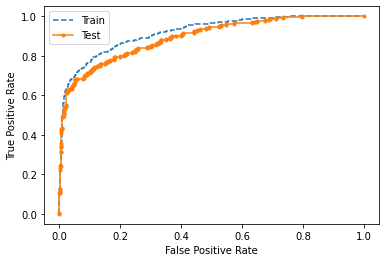

In [31]:
classification_evaluation(m_lr, X_train, y_train, X_test, y_test)

As you can see, `sklearn.metrics` is versatile and allows you to calculate and plot a bunch of different performance metrics. In our case, this model gives a test AUC of 0.742. The worst possible is 0.5 - random guessing. We've built a pretty good model!


### Classification Trees 
We will briefly explore classification trees (often referred to as CART, for Classification And Regression Trees).

A (binary) classification tree makes predictions by grouping similar observations and then assigning a probability to each group using the proportion of observations within that group that belong to the positive class. Groups can be thought of as nodes on a tree, and tree branches correspond to logical criteria on the predictor variables. There's a lot of neat math that goes into building the trees, but we won't get into that today. For now let's get familiarized by looking at a simple example. We will use the `DecisionTreeClassifier` in scikit-learn.	

#### Tuning the CART model
If we want to construct high accuracy decision tree models, then we need to tune the parameters.  CART has many parameters that specify how the decision tree is constructed. Today we'll focus on `max_depth`. 
* If the tree is too big => too many splits => we have an over-fitting problem.
* If the tree is too small => too few splits => we have an under-fitting problem.

We want to find a tree in the middle, that is "just right". We'll use `GridSearchCV` package to tune the tree depth using cross-validation. We'll also try out a couple of different criteria.

The model construction step follows the same established pattern.

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Define the grid that we want to search over
param_grid = {"max_depth": np.arange(3,10,1), "criterion": ['gini', 'entropy']}

# Define the parameters for the model 
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_cart = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 7}


We can plot and save the resulting tree as follows:	

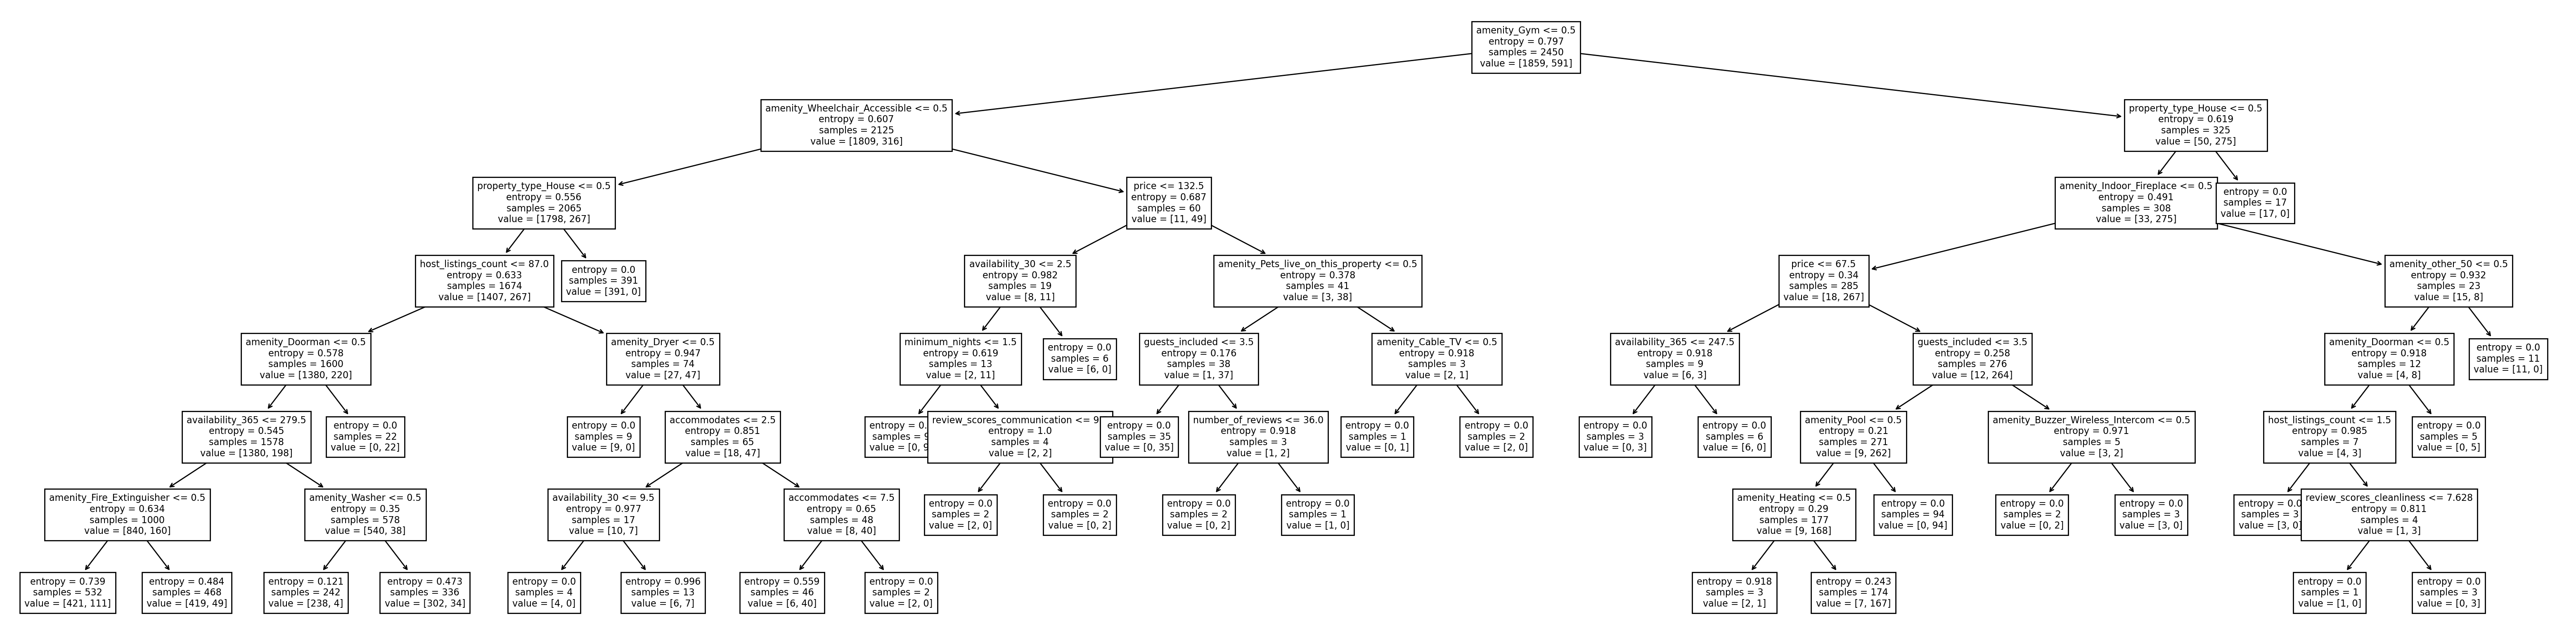

In [33]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (40,10), dpi=200)
plot_tree(m_cart, feature_names = X_train.columns, filled = False, fontsize = 8);
fig.savefig('cart_tree.png')

Let's use our evaluation function from before to see how well this model performs! 

Train AUC: 0.911
Test AUC: 0.861

Train Accuracy: 0.911
Test Accuracy: 0.892


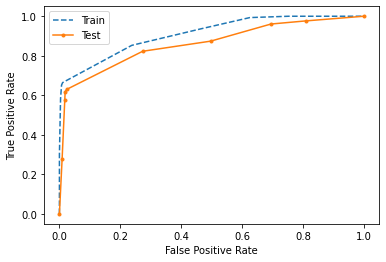

In [34]:
classification_evaluation(m_cart, X_train, y_train, X_test, y_test)

### Random Forests
We will briefly take a look at random forests, using the [RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). A random forest is a collection of slightly randomized decision trees (hence the name "forest"), and can be used for classification or prediction. They often have excellent predictive performance, but can be expensive to train and lack interpretability. Random forests have many hyperparameters that can be tuned to achieve the best possible predictive performance. Perhaps the most important hyperparameter is the number of trees to include in the forest. More trees results in a longer training time but can improve prediction and decrease overfitting.

Let's start by training a random forest model for a classification task. We will perform the same task of predicting whether or not a listing has an elevator, using price and neighborhood as predictors. We will compare the performance of random forest to what we got using our simple CART model. We'll use a grid search to tune the number of estimators.

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100,500,1000],
     'max_depth': np.arange(5,10,1),
     'max_features': ['auto'],
     'min_samples_leaf': [0.01,0.02],
    'criterion' :['gini']
}
        
# Define the parameters for the model 
gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_rf = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 0.01, 'n_estimators': 1000}


Train AUC: 0.943
Test AUC: 0.895

Train Accuracy: 0.877
Test Accuracy: 0.883


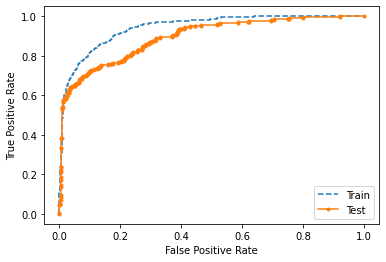

In [36]:
# Let's evaluate the model performance
classification_evaluation(m_rf, X_train, y_train, X_test, y_test)

Compare this to what we got using CART, which had training AUC of 0.861. The tuned random forest model improves on the CART model. In general, random forests give stronger performance than single decision trees, but there is a sacrifice in interpretability. Interestingly, the logistic regression model is almost identical in performance to random forests.

#### Interpreting a Random Forest Model

The prediction accuracy is now much better, and it doesn't look we are overfitting too much. It would likely be even better if the other hyperparameters of the random forest model were properly tuned! Although random forest models are not very interpretable and hard to visualize, there is a popular method called *variable importance* that is commonly used with random forest models. We will use the built-in `feature_importances_` in our random forest model. This tells us which variables the random forest model has determined are the most important for predicting whether or not a listing contains an elevator. It uses Gini importance, which is the mean decrease in node impurity (you can read more about this metric online), to rank the importance of all of the predictors used in the model. There are other metrics besides the Gini Importance that can also be used as a metric.

<BarContainer object of 10 artists>

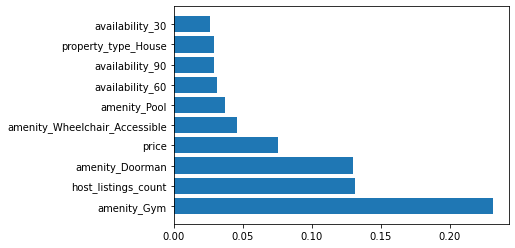

In [37]:
importance_output = pd.DataFrame({'feature':X_train.columns,
                                 'importance':m_rf.feature_importances_}).sort_values('importance', ascending = False)

plt.barh(importance_output['feature'][0:10], importance_output['importance'][0:10])

The variable importance plot shows us that whether or not the unit has a gym, how many listings the host has, whether there is a doorman, and the unit price are the most important features. This not only gives us intuition about our random forest model, but can also be used to select variables to train other models. However, there are some shortcomings. For example, price is important in the model, but what is the direction of this relationship? Are high or low prices associated with elevator likelihood?

#### Interpretation with SHapley Additive exPlanations (SHAP)
There has been a lot of research devoted to better methods of interpreting "black box" machine learning models, like random forests. The [SHAP](https://shap.readthedocs.io/en/latest/) package offers an easy-to-use interface that estimates the contribution of each variable to each observation's prediction. This gives insight into both the *magnitude* and *directionality* of a feature's importance. The package also allows for plots of interactions between variables to understand important nonlinearities. We'll do this for the random forest model, but we could use the same package for many other models.

In [38]:
import shap  ## you can install this in terminal: 'conda install -c conda-forge shap'

explainer = shap.TreeExplainer(m_rf); # data=test_x, model_output="probability");
shap_values = explainer.shap_values(X_train)[1]; # index pulls the P(y=1) SHAP values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


We'll start with the summary plot, which ranks the features by importance (mean absolute SHAP value) and also shows the direction of the relationship. 

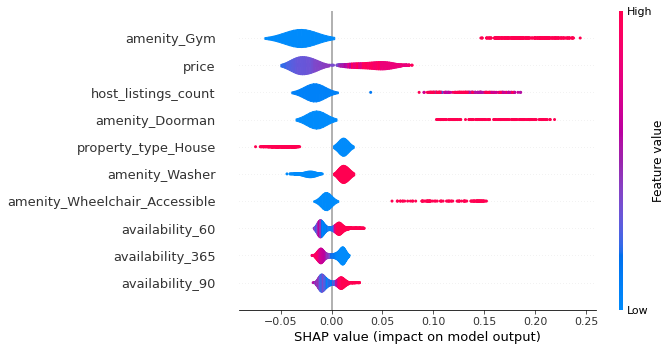

In [39]:
plt.close()
shap.summary_plot(shap_values, X_train, show=True,
                  max_display=10,
                  plot_type="violin")

The summary plot gives us insight into the key driving features; this is similar to Gini feature importance but gives us more granular insight.
- Gym, Doorman, Washer, Wheelchair Accessible amenities all increase the probability of an elevator.
- As price increeases, the probability of an elevator increases.
- Listings from hosts with more listings have higher probability of an elevator.
- The property type being a house decreases the probability.

##### Dependence Plots

Let's dive into the relationship between price and whether the unit is predicted to have an elevator. We can create a dependence plot or price to see how varied prices affect the output probability.

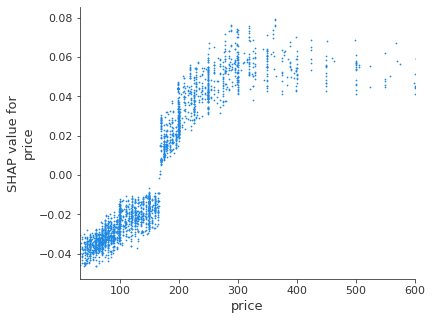

In [40]:
plt.close()
shap.dependence_plot('price', shap_values, X_train,
                       interaction_index = None,
                       xmin="percentile(1)", xmax="percentile(99)",
                       dot_size=3,show=False)

It looks like listings for listings below \\$200/night, the price lowers thee probability that the unit will have an elevator (SHAP value < 0). Above \\$200/night, there is a positive impact on probability of having an elevator. Above \\$300/night or so, however, the impact on the probability stabilizes; the probability does not continue to increase with prices above \\$300. 

###### Force Plots
Finally, force plots let us see how each feature contributes to the final probability for a given observation. The red features contribute to increases in the elevator probability, and the blue features decrease. The width of the bar (decreasing from the center) indicates the magnitude. 

In [41]:
id=4 # Try id=1 and id=4 to see a high and low probability example
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[id],
               feature_names = X_train.columns)

### Model Selection
**Question:** Now that we have trained and evaluated these different models, which one would you select?

**Answer:** It depends on the application, the stakeholders, and the costs of missed positives and negatives (or in continuous prediction, under- and over-predictions). In a problem like this, the prediction of whether an Airbnb listing will have an elevator is not highly consequential. However, consider a clinical decision support tool that predicts hospital re-admission or a model that predicts loan defaults. In such cases, there may be a higher premium on interpretability to ensure transparency for patients (or bank clients). On the other hand, a tool that is used to triage customer service  calls within a company may not need to be as interpretable because it is used purely internally. 

## Conclusions
In this module, we have covered examples of machine learning methods for linear regression (ordinary and penalized) and classification.  This is just the tip of the iceberg.  There are tons more machine learning methods which can be easily implemented in Python.  

### Notes on sklearn modeling
- While the examples above used CART and Random Forests for classification tasks, there is almost identical syntax to run them for regression tasks. We won't go through these in details, but check out [DecisionTreeRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for more information. 
- There are many, many classification algorithms implemented in `scikit-learn`. [Here's](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) an example that compares a broad set of methods, including SVM, k-Nearest Neighbors, and others.
- XGBoost follows nearly identical syntax to the examples above (using GridSearchCV). However, it is not implemented in scikit-learn. You can install the [xgboost](https://xgboost.readthedocs.io/en/latest/) library and then adapt the code above to this model.